# Change Detection: CUSUM vs CPM

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.Plotter import Plotter 
from src.data import generate_data

In [3]:
import numpy as np
from src.ChangeDetector import ChangeDetector


def run(x: np.ndarray,
        y: np.ndarray,
        detector: ChangeDetector,
        cp_gt: int = None) -> None:
    cps, stats = detector.detect_changes(y)

    if len(cps) > 0:
        cp = cps[0]
        print(f"Change detected with delay {cp - cp_gt}")
    else:
        cp = None
        print("No change detected")

    title = f"Monitoring with {detector}"
    Plotter().plot(x=x, y=y,
                   stats=stats, thr=detector.thr,
                   cp=cp, cp_gt=cp_gt,
                   title=title)

### Generate data

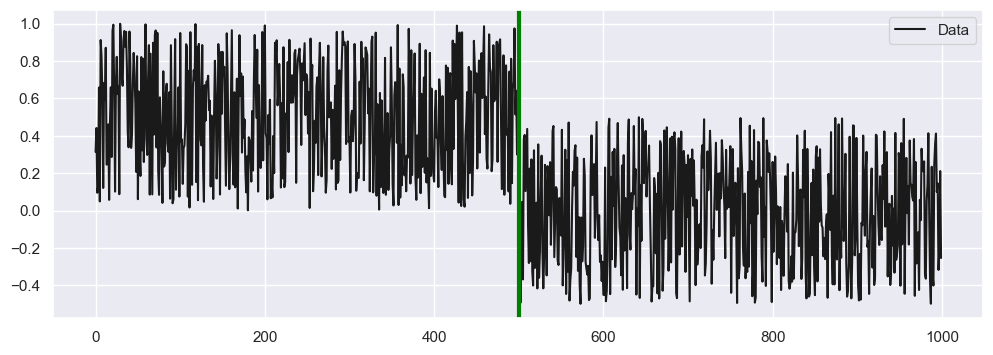

In [4]:
x, y, cp_gt = generate_data()
Plotter().plot(x, y, cp_gt=cp_gt)

In [5]:
cp_gt

500

### Monitoring with CUSUM

Change detected with delay 20


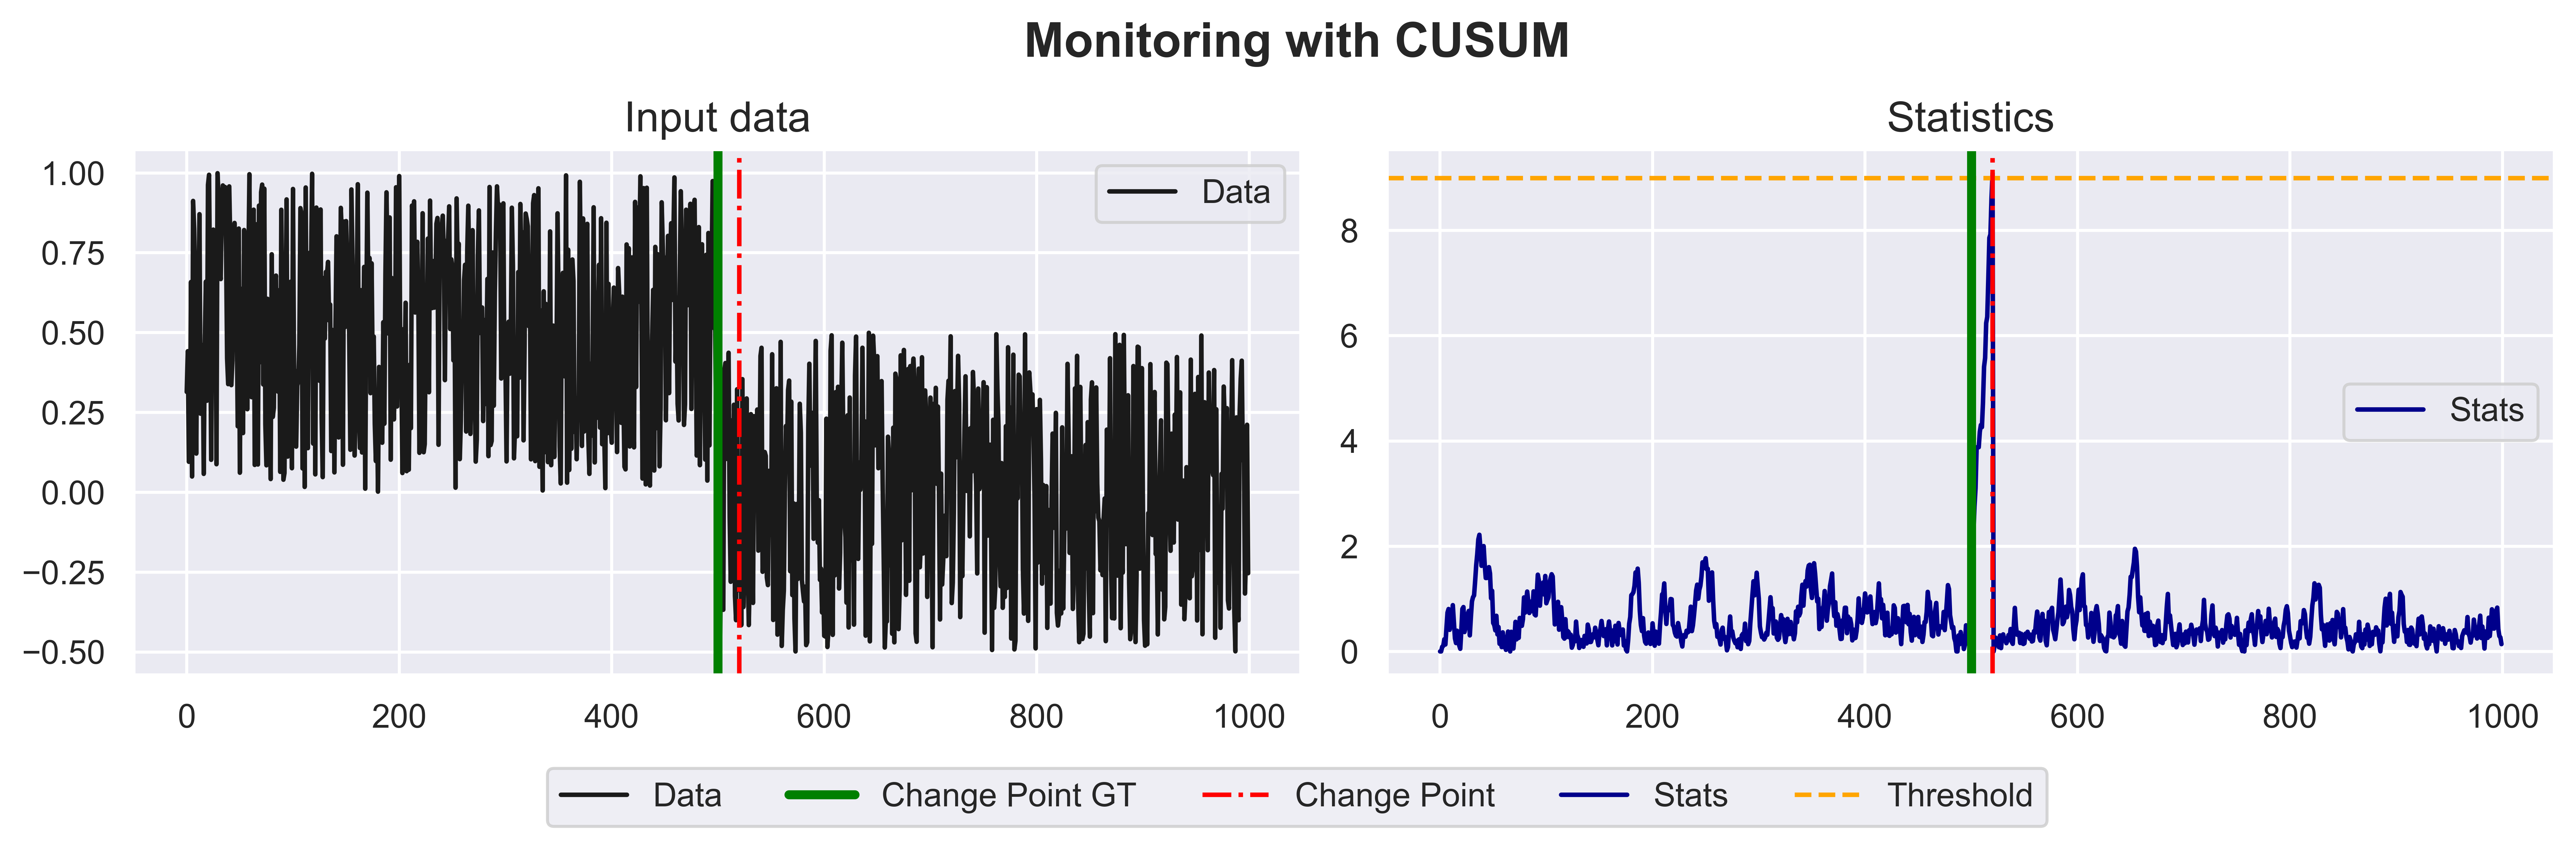

In [6]:
from src.CUSUM import CUSUM

thr = 9.
run(x, y, detector=CUSUM(thr=thr), cp_gt=cp_gt)

### Monitoring with CPM

Change detected with delay 0


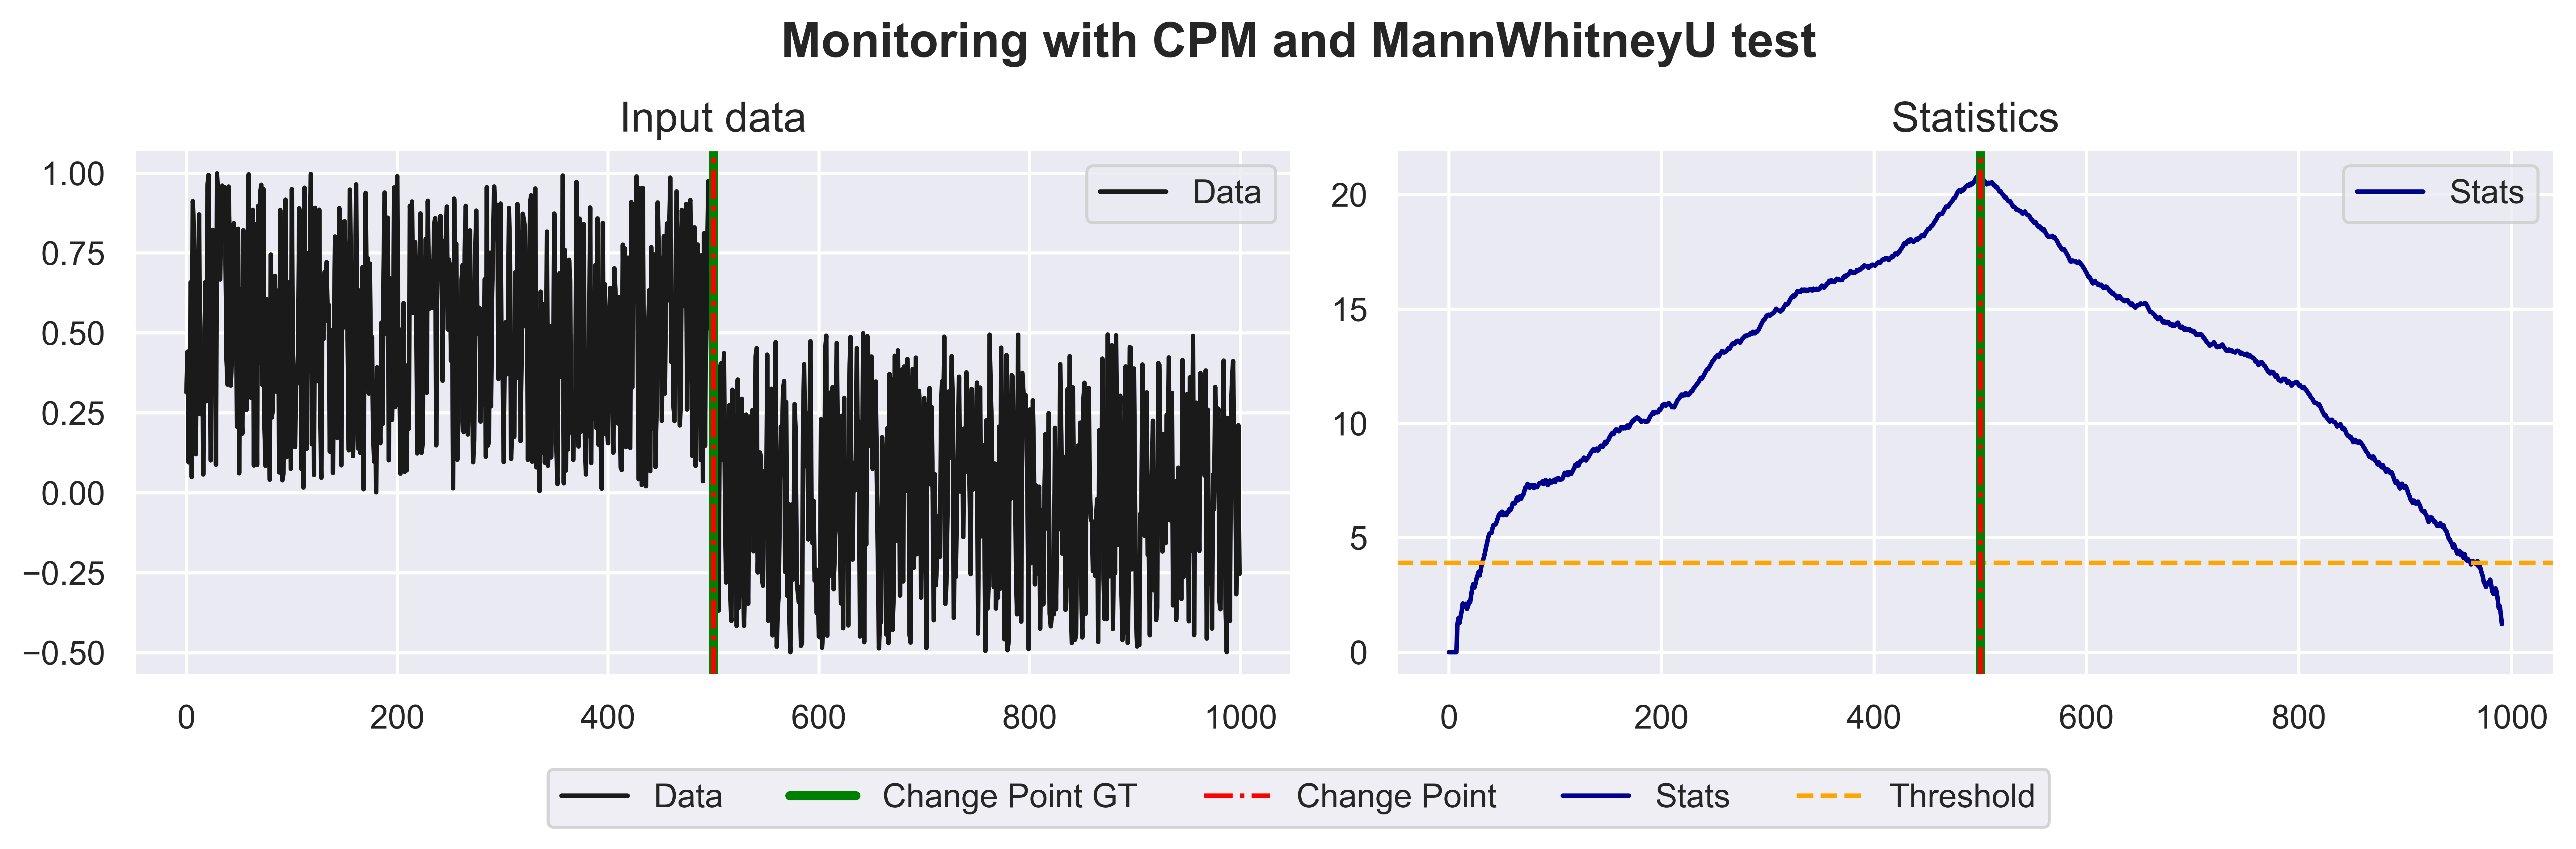

No change detected


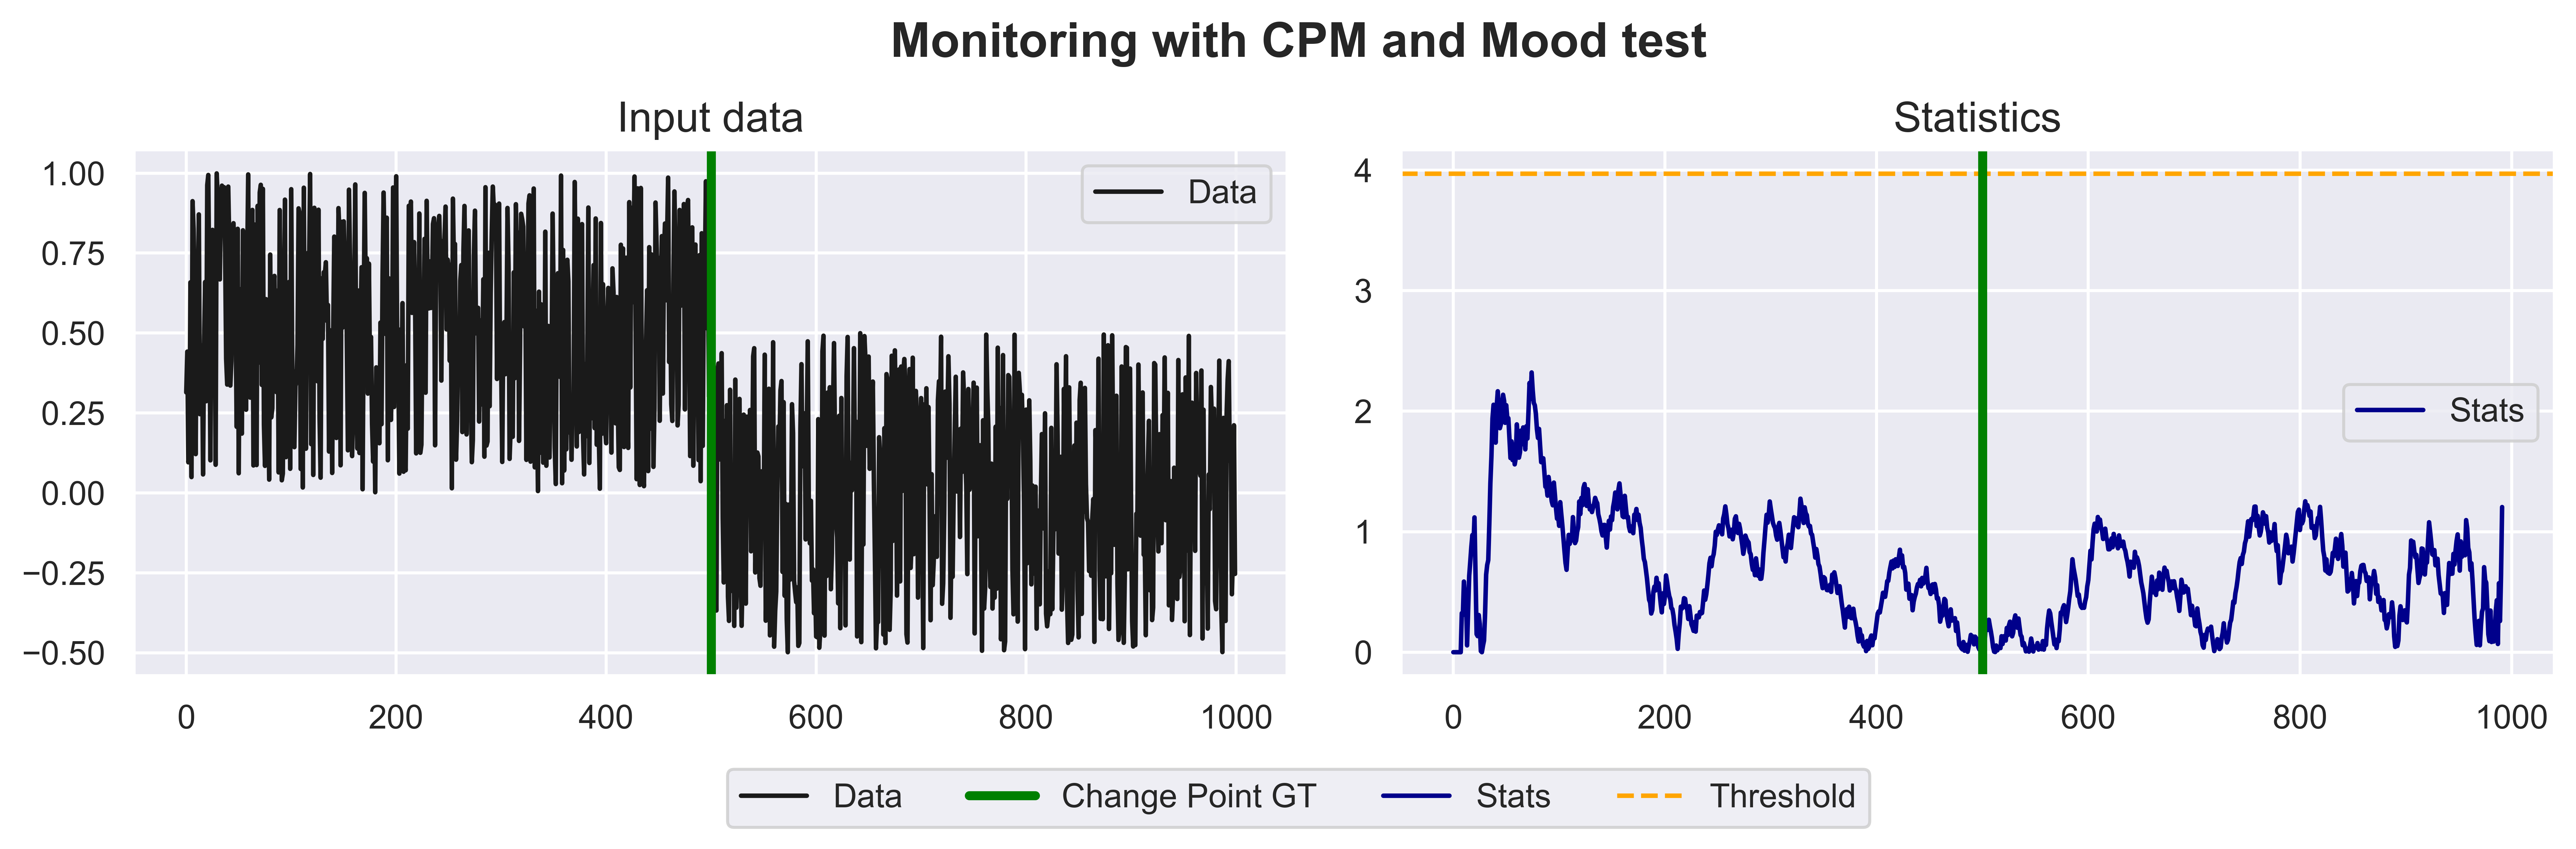

Change detected with delay 0


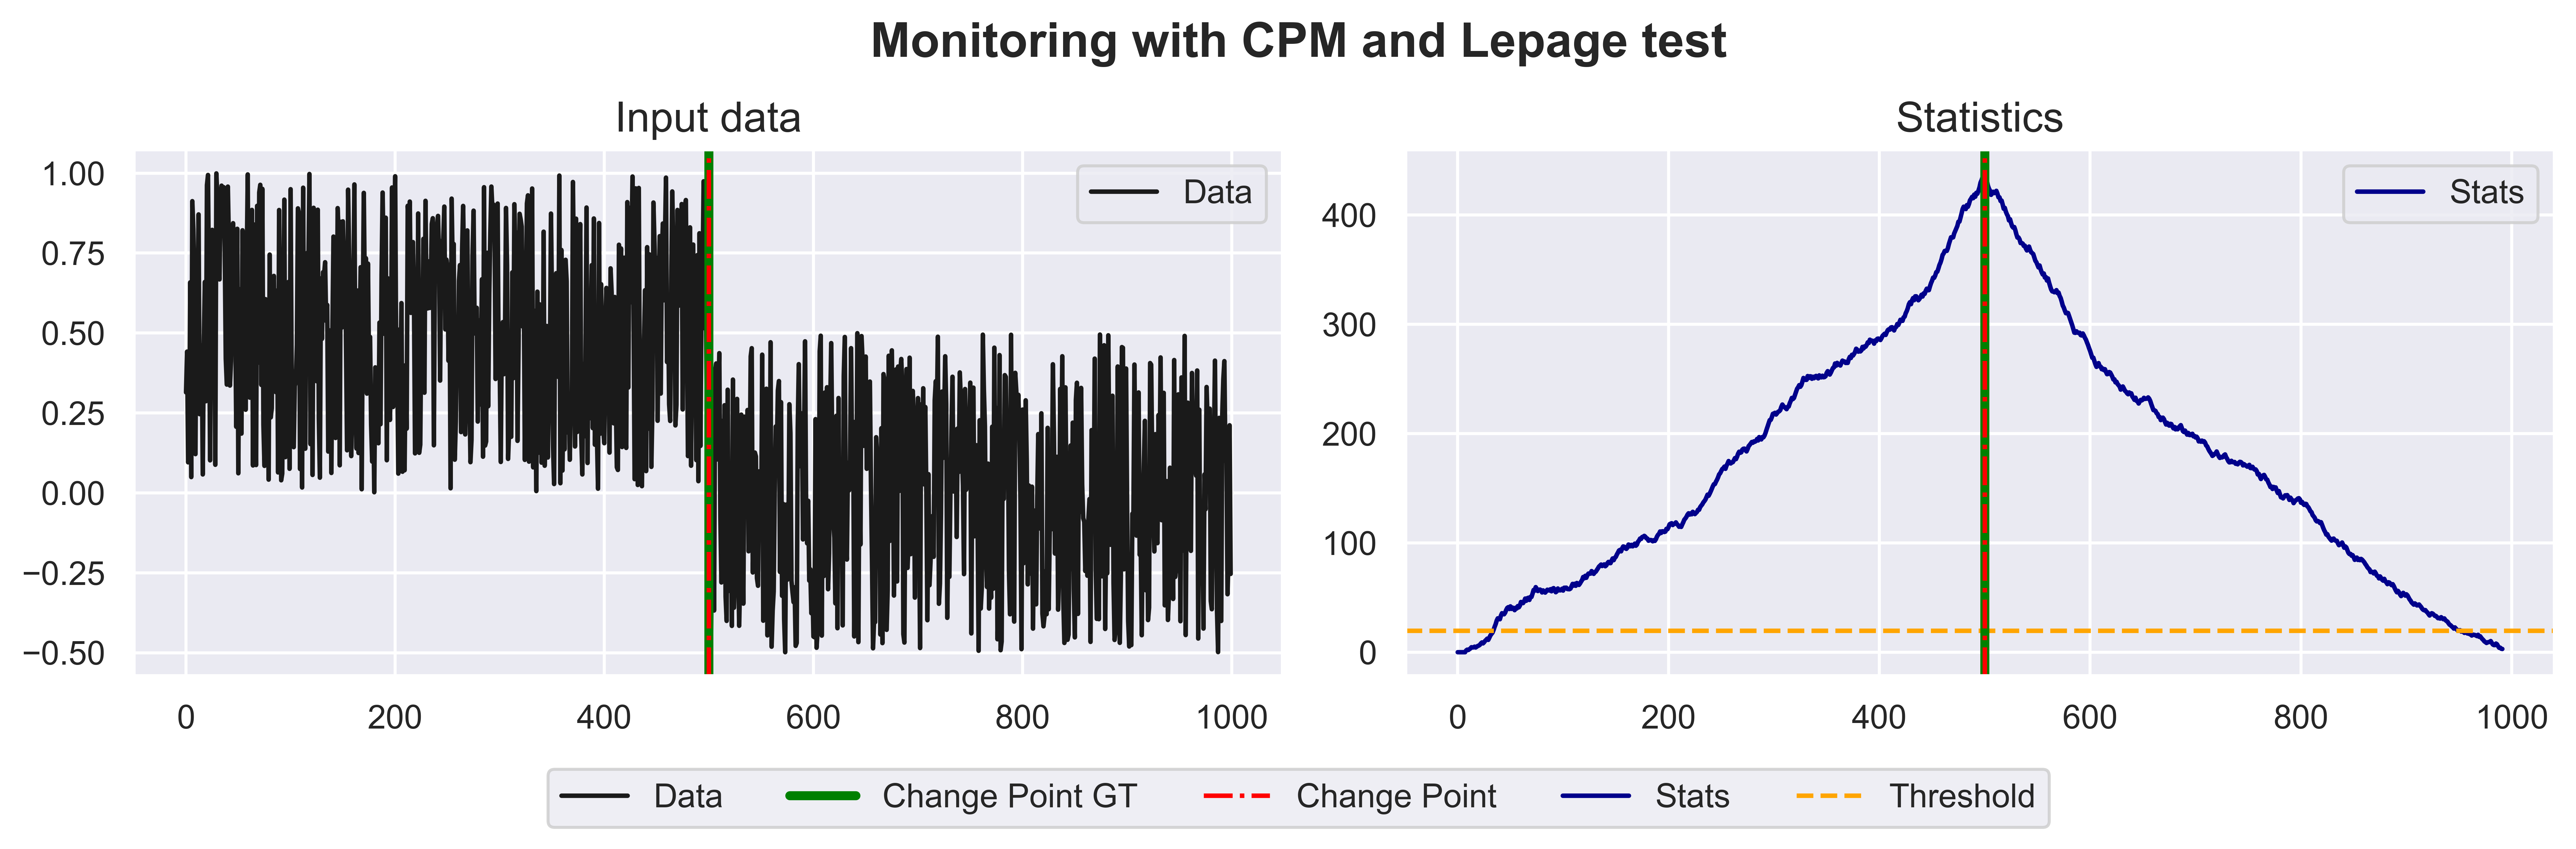

In [7]:
from src.CPM import CPM
from src.StatisticalTest import MannWhitneyU, Mood, Lepage

# Note: we use the same thresholds from the CPM library available in R, with the significance level (alpha) set to 0.005.
run(x, y, CPM(test=MannWhitneyU, thr=3.9090), cp_gt=cp_gt)
run(x, y, CPM(test=Mood, thr=3.9723), cp_gt=cp_gt)
run(x, y, CPM(test=Lepage, thr=19.6325), cp_gt=cp_gt)

# Note: the Mood test detects changes in scale (variance), but we are only shifting the mean of the data stream. Therefore, we expect it to detect no changes.

### Remarks

- The CPM method, using Mann-Whitney and Lepage tests, achieves zero error.

- While CUSUM analyzes the data stream one sample at a time, CPM considers the entire dataset to identify the optimal split that maximizes the statistic.

### Comparison between our implementation and the one available in the R library

In [8]:
from src.CPM import CPM
from src.StatisticalTest import MannWhitneyU, Mood, Lepage

min_obs = 8
_, stats_mw = CPM(test=MannWhitneyU, min_obs=min_obs).detect_changes(y)
_, stats_mo = CPM(test=Mood, min_obs=min_obs).detect_changes(y)
_, stats_lp = CPM(test=Lepage, min_obs=min_obs).detect_changes(y)

In [9]:
from src.cpm_r import cpm_r

stats_mw_r = cpm_r(y, 'Mann-Whitney', min_obs=min_obs)
stats_mo_r = cpm_r(y, 'Mood', min_obs=min_obs)
stats_lp_r = cpm_r(y, 'Lepage', min_obs=min_obs)

Difference Ours and R versions: 1.7821522035887938e-11


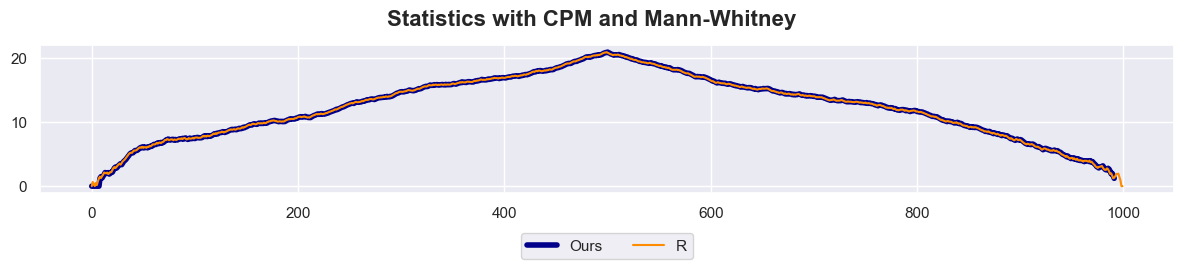

Difference Ours and R versions: 7.218722960968676e-13


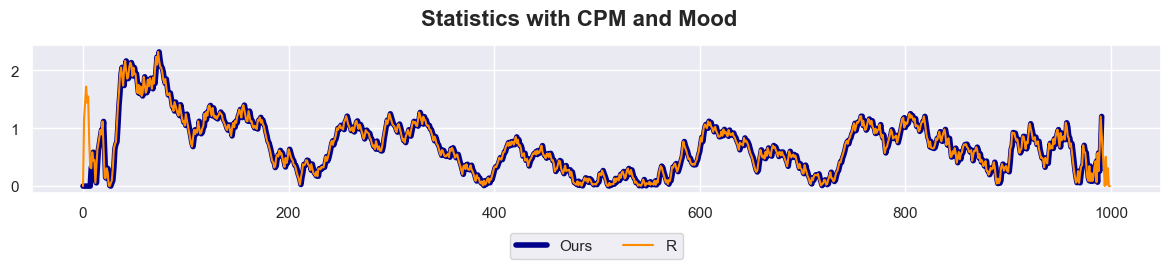

Difference Ours and R versions: 1.740310118236721e-10


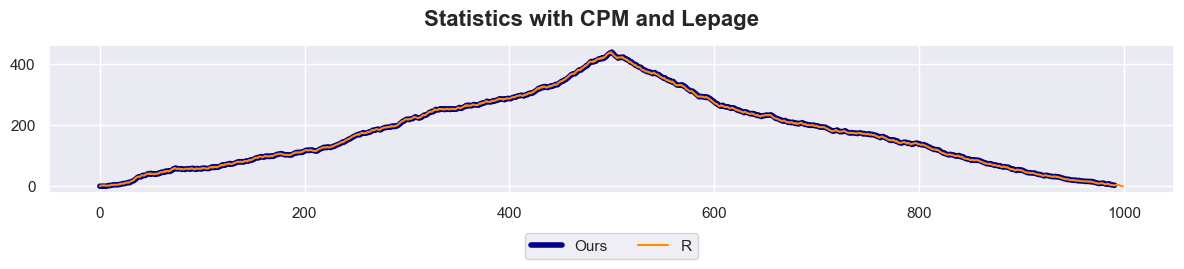

In [10]:
plotter = Plotter()

plotter.compare_stats(stats1=stats_mw, stats2=stats_mw_r, min_obs=min_obs,
                      title='Statistics with CPM and Mann-Whitney')
plotter.compare_stats(stats1=stats_mo, stats2=stats_mo_r, min_obs=min_obs,
                      title='Statistics with CPM and Mood')
plotter.compare_stats(stats1=stats_lp, stats2=stats_lp_r, min_obs=min_obs,
                      title='Statistics with CPM and Lepage')

### Remarks

The difference between the two versions is **negligible**, meaning the Python version can effectively replace the R version. This allows Python users to perform their Change Detection experiments relaxing the need to install R.